pairs: (1513, 4)
  leading_item_id following_item_id  best_lag  max_corr
0        AANGBULD          APQGTRMF         5 -0.443984
1        AANGBULD          DEWLVASR         6  0.640221
2        AANGBULD          DNMPSKTB         4 -0.410635
3        AANGBULD          EVBVXETX         6  0.436623
4        AANGBULD          FTSVTTSR         3  0.531400


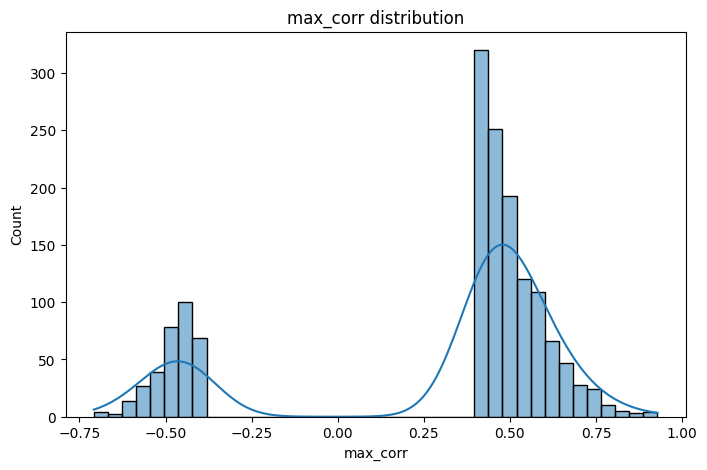

Positive corr: 0.7799074686054197
Negative corr: 0.2200925313945803


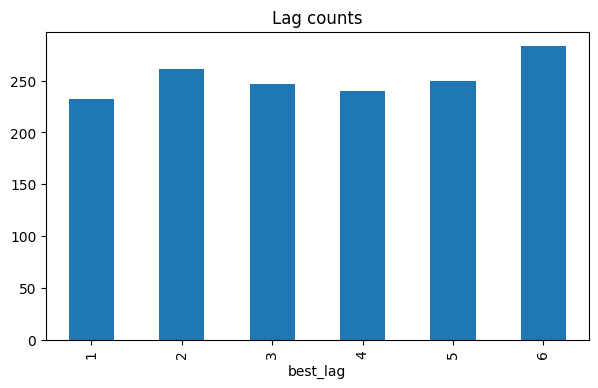

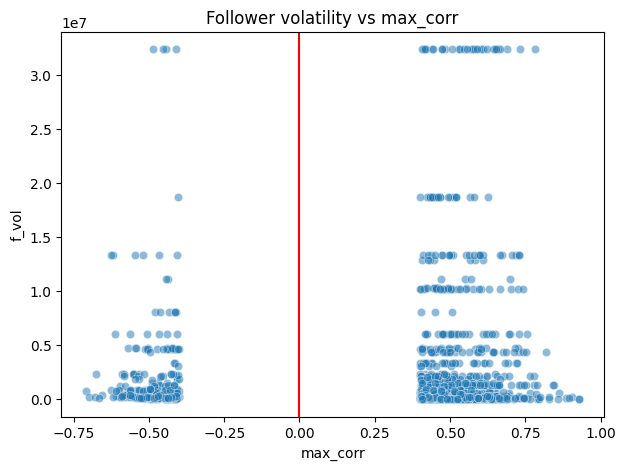

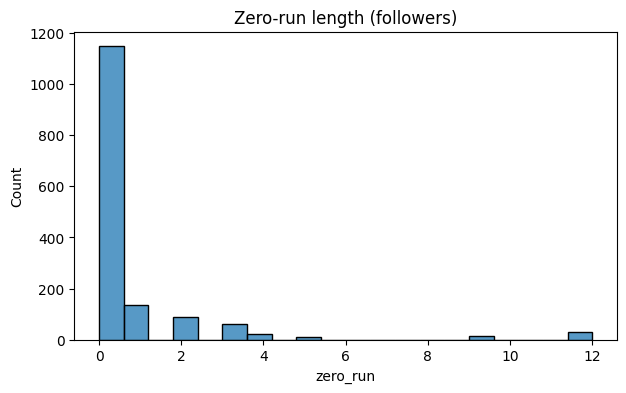

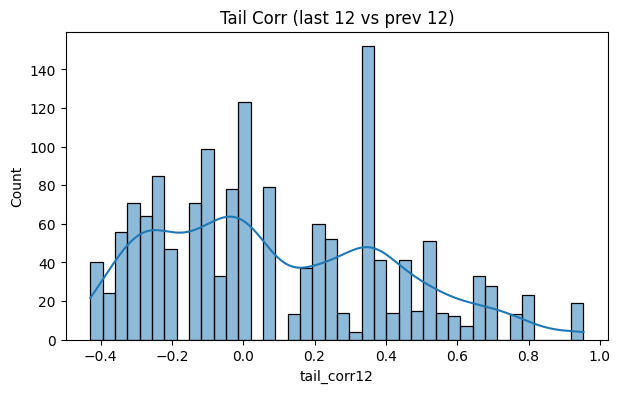

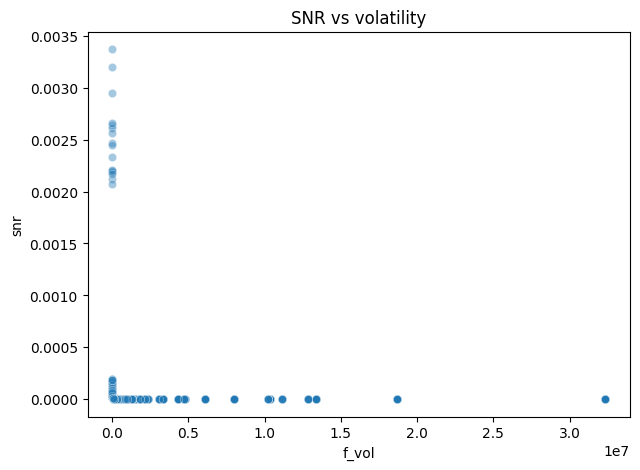

          max_corr         f_vol           snr
count  1513.000000  1.513000e+03  1.513000e+03
mean      0.291664  2.411563e+06  3.476282e-05
std       0.417042  5.636353e+06  2.601876e-04
min      -0.708337  1.971710e+02  1.259365e-08
25%       0.404034  1.025814e+05  3.169810e-07
50%       0.452861  3.400022e+05  1.408643e-06
75%       0.531686  1.492172e+06  4.866042e-06
max       0.928613  3.234730e+07  3.374296e-03

=== Filter Presets Preview ===
Filtered pairs: 16
corr>0 : 16
Filtered pairs: 16
corr>0.2 : 16
Filtered pairs: 12
lag<=5 : 12
Filtered pairs: 16
tail_corr12>0 : 16
Filtered pairs: 0
f_vol<1.0 : 0
Filtered pairs: 0
zero_run<=2 : 0

=== Multi-filter Example ===
Filtered pairs: 12
corr>0, lag<=5, tail>0 : 12


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ============================================================
# PATH
# ============================================================
BASE_DIR = Path.cwd().resolve()
DATA_DIR = BASE_DIR.parents[1] / "data"

PAIR_PATH = DATA_DIR / "processed" / "v10_pairs" / "pairs_v10_th40.csv"

# 만약 pivot도 필요하면 로드
PIVOT_PATH = DATA_DIR / "processed" / "v10_pairs" / "monthly_pivot_v10.csv"


# ============================================================
# 1. Load pair data
# ============================================================
pairs = pd.read_csv(PAIR_PATH)
pivot = pd.read_csv(PIVOT_PATH, index_col=0)
pivot.index = pd.to_datetime(pivot.index)

print("pairs:", pairs.shape)
print(pairs.head())


# ------------------------------------------------------------
# Helper: zero-run-length 계산
# ------------------------------------------------------------
def zero_run_length(series):
    max_run = 0
    current = 0
    for v in series:
        if v == 0:
            current += 1
            max_run = max(max_run, current)
        else:
            current = 0
    return max_run


# ============================================================
# 2. Corr distribution
# ============================================================
plt.figure(figsize=(8,5))
sns.histplot(pairs["max_corr"], bins=40, kde=True)
plt.title("max_corr distribution")
plt.show()

# positive/negative ratio
print("Positive corr:", (pairs["max_corr"] > 0).mean())
print("Negative corr:", (pairs["max_corr"] < 0).mean())


# ============================================================
# 3. Lag distribution
# ============================================================
plt.figure(figsize=(7,4))
pairs["best_lag"].value_counts().sort_index().plot(kind="bar")
plt.title("Lag counts")
plt.show()


# ============================================================
# 4. Follower volatility vs corr
# ============================================================
# follower volatility 직접 계산
vol_list = []
zero_run_list = []
tail_corr_list = []

for _, row in pairs.iterrows():
    f = pivot[row["following_item_id"]].values
    vol = np.std(f)
    vol_list.append(vol)

    # zero-run
    zr = zero_run_length(f)
    zero_run_list.append(zr)

    # tail corr 12개월
    if len(f) >= 24:
        tail_corr = np.corrcoef(f[-12:], f[-24:-12])[0, 1]
    else:
        tail_corr = 0
    tail_corr_list.append(tail_corr)

pairs["f_vol"] = vol_list
pairs["zero_run"] = zero_run_list
pairs["tail_corr12"] = tail_corr_list


plt.figure(figsize=(7,5))
sns.scatterplot(data=pairs, x="max_corr", y="f_vol", alpha=0.5)
plt.axvline(0, color="red")
plt.title("Follower volatility vs max_corr")
plt.show()


# ============================================================
# 5. zero-run distribution
# ============================================================
plt.figure(figsize=(7,4))
sns.histplot(pairs["zero_run"], bins=20, kde=False)
plt.title("Zero-run length (followers)")
plt.show()


# ============================================================
# 6. tail_corr12 distribution
# ============================================================
plt.figure(figsize=(7,4))
sns.histplot(pairs["tail_corr12"], bins=40, kde=True)
plt.title("Tail Corr (last 12 vs prev 12)")
plt.show()


# ============================================================
# 7. SNR (signal to noise ratio = |corr| / vol)
# ============================================================
pairs["snr"] = np.abs(pairs["max_corr"]) / (pairs["f_vol"] + 1e-6)

plt.figure(figsize=(7,5))
sns.scatterplot(data=pairs, x="f_vol", y="snr", alpha=0.4)
plt.title("SNR vs volatility")
plt.show()

print(pairs[["max_corr","f_vol","snr"]].describe())


# ============================================================
# 8. Candidate filter simulation (대장 원하는 threshold 실험)
# ============================================================

def preview_filter(
    corr_th=0,
    lag_max=6,
    tail_th=-1,
    vol_max=999,
    zero_run_max=99,
):
    df = pairs.copy()
    df = df[df["max_corr"] > corr_th]
    df = df[df["best_lag"] <= lag_max]
    df = df[df["tail_corr12"] > tail_th]
    df = df[df["f_vol"] < vol_max]
    df = df[df["zero_run"] <= zero_run_max]
    print(f"Filtered pairs: {len(df)}")
    return df

print("\n=== Filter Presets Preview ===")
print("corr>0 :", len(preview_filter(corr_th=0)))
print("corr>0.2 :", len(preview_filter(corr_th=0.2)))
print("lag<=5 :", len(preview_filter(lag_max=5)))
print("tail_corr12>0 :", len(preview_filter(tail_th=0)))
print("f_vol<1.0 :", len(preview_filter(vol_max=1.0)))
print("zero_run<=2 :", len(preview_filter(zero_run_max=2)))


print("\n=== Multi-filter Example ===")
print("corr>0, lag<=5, tail>0 :", len(preview_filter(corr_th=0, lag_max=5, tail_th=0)))


=== Shape ===
(1513, 18)

=== Columns ===
['leading_item_id', 'following_item_id', 'best_lag', 'max_corr', 'corr_early', 'corr_mid', 'corr_recent', 'trend_leader', 'trend_follower', 'trend_match', 'rollcorr_std', 'dtw_dist', 'snr_detrend', 'hs4_leader', 'hs4_follower', 'hs4_equal', 'hs4_prefix2_equal', 'hs4_dist']

=== Describe (전체 수치형) ===


,count,mean,std,min,25%,50%,75%,max
best_lag,1513.0,3.571051e+00,1.721828e+00,1.000000e+00,2.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00
max_corr,1513.0,2.916641e-01,4.170419e-01,-7.083373e-01,4.040340e-01,4.528613e-01,5.316864e-01,9.286132e-01
corr_early,1513.0,2.774126e-01,4.071396e-01,-7.026847e-01,-8.239090e-03,4.438868e-01,5.711651e-01,9.780081e-01
corr_mid,1513.0,1.318618e-01,3.941728e-01,-7.368440e-01,-1.722112e-01,1.970061e-01,4.559721e-01,9.887550e-01
corr_recent,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trend_leader,1513.0,-1.035370e+05,2.994284e+05,-1.865238e+06,-6.355103e+04,-4.050371e+03,1.385427e+02,1.012330e+05
trend_follower,1513.0,-9.565562e+04,3.078943e+05,-1.865238e+06,-2.606082e+04,-2.628509e+03,1.774764e+02,1.012330e+05
trend_match,1513.0,4.157303e-01,9.097886e-01,-1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
rollcorr_std,1513.0,2.823184e-01,9.930156e-02,6.646611e-02,2.091405e-01,2.724139e-01,3.475736e-01,6.129616e-01
dtw_dist,1513.0,3.415920e+08,6.601361e+08,7.630900e+04,1.263799e+07,9.288039e+07,2.839110e+08,4.671899e+09


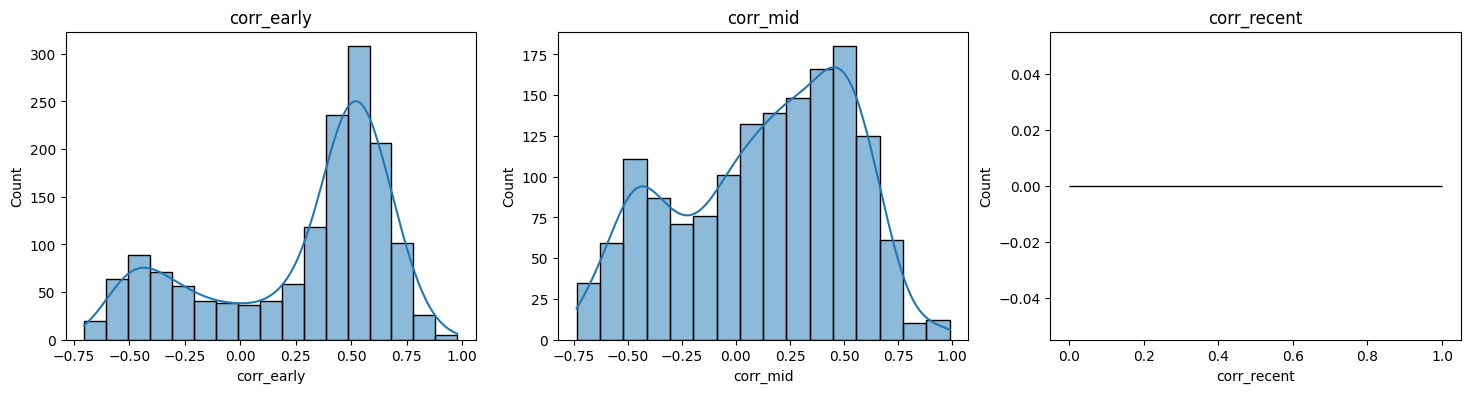

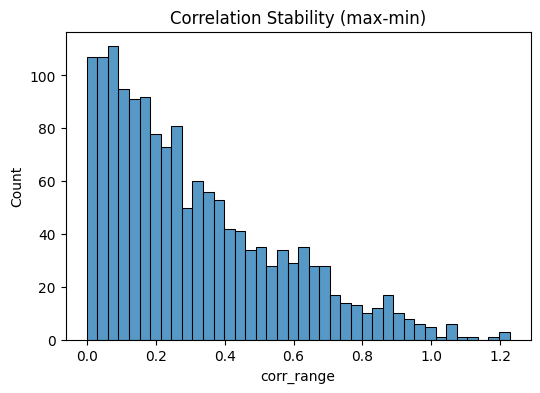

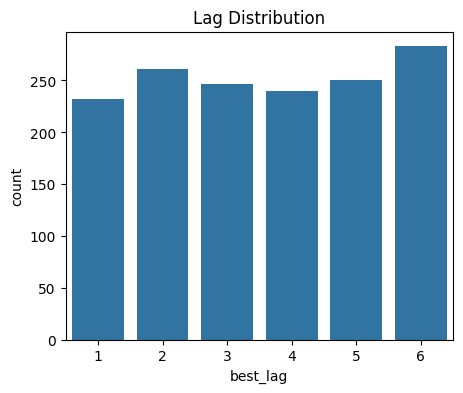

/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


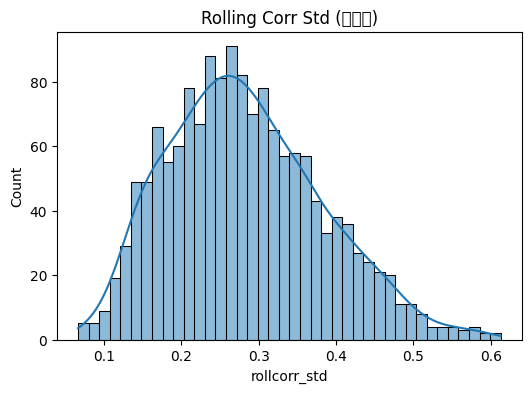

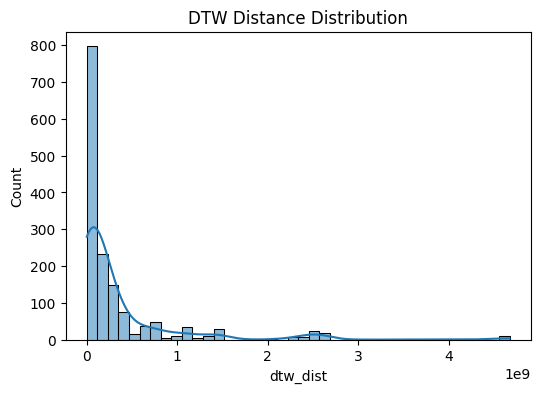

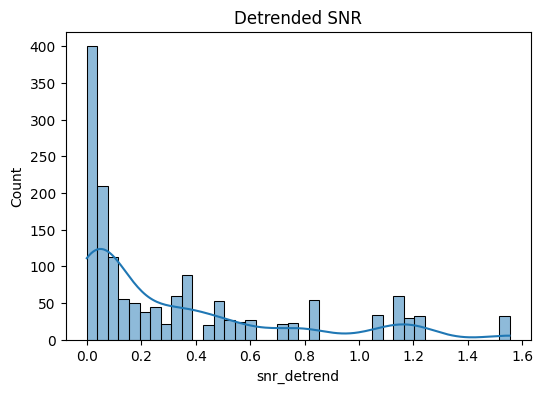

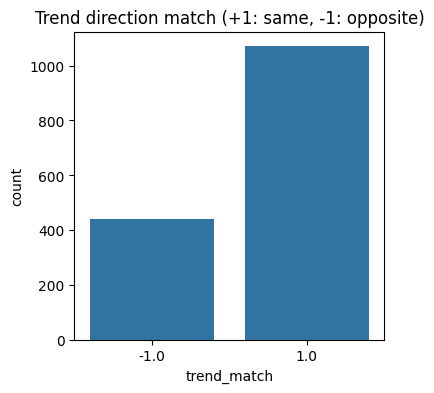

/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


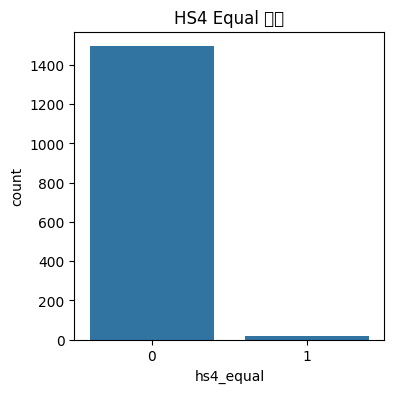

/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50526 (\N{HANGUL SYLLABLE AP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) miss

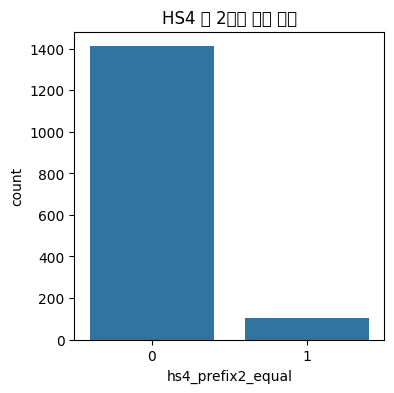

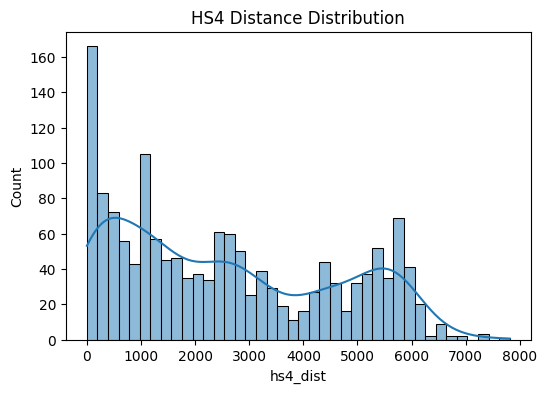

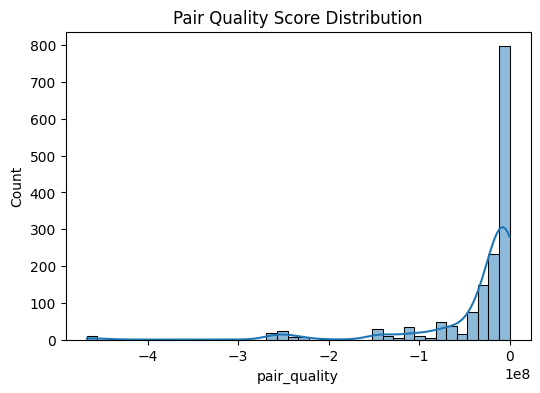


=== Top 20 Best Pairs ===


,leading_item_id,following_item_id,best_lag,max_corr,corr_early,corr_mid,corr_recent,trend_leader,trend_follower,trend_match,rollcorr_std,dtw_dist,snr_detrend,hs4_leader,hs4_follower,hs4_equal,hs4_prefix2_equal,hs4_dist,corr_range,pair_quality
966,QSDCUCLB,DJBLNPNC,6,0.794174,0.866919,0.160042,NaN,-4.137723,-26.745092,1.0,0.344152,76309.0,0.004336,2710,2805,0,0,95,0.706877,-7630.850130
307,DJBLNPNC,FDXPMYGF,3,0.828726,0.864942,0.493369,NaN,-26.745092,-76.256569,1.0,0.270777,126711.0,0.007355,2805,7907,0,0,5102,0.371572,-12670.968987
471,FWUCPMMW,FDXPMYGF,3,0.617665,0.905538,-0.107827,NaN,65.526276,-76.256569,-1.0,0.477602,163826.0,0.007355,2701,7907,0,0,5206,1.013365,-16382.626532
475,FWUCPMMW,NAQIHUKZ,3,0.584915,-0.017613,0.969247,NaN,65.526276,85.900332,1.0,0.573206,175080.0,0.007318,2701,3813,0,0,1112,0.986861,-17507.922553
34,ANWUJOKX,FDXPMYGF,6,0.432740,0.455588,-0.188283,NaN,-546.688010,-76.256569,1.0,0.271364,213466.0,0.007355,4403,7907,0,0,3504,0.643872,-21346.646371
408,FDXPMYGF,JERHKLYW,6,0.487122,0.588838,0.228273,NaN,-76.256569,173.409997,-1.0,0.392777,229116.0,0.102000,7907,4601,0,0,3306,0.360564,-22911.574017
1442,YSYHGLQK,ZXERAXWP,5,0.433898,0.477820,0.113272,NaN,56.642102,236.507702,1.0,0.472173,245547.0,0.171941,2807,4802,0,0,1995,0.364548,-24554.723998
303,DJBLNPNC,ANWUJOKX,2,0.523656,0.523681,0.343497,NaN,-26.745092,-546.688010,1.0,0.477889,268230.0,0.125089,2805,4403,0,0,1598,0.180184,-26822.974510
32,ANWUJOKX,DJBLNPNC,3,0.498243,0.550443,-0.049269,NaN,-546.688010,-26.745092,1.0,0.264603,268230.0,0.004336,4403,2805,0,0,1598,0.599713,-26823.007730
1035,RCBZUSIM,FDXPMYGF,5,0.544848,0.645185,0.113039,NaN,-364.416490,-76.256569,1.0,0.301642,317932.0,0.007355,2805,7907,0,0,5102,0.532146,-31793.173202



=== Bottom 20 Worst Pairs ===


,leading_item_id,following_item_id,best_lag,max_corr,corr_early,corr_mid,corr_recent,trend_leader,trend_follower,trend_match,rollcorr_std,dtw_dist,snr_detrend,hs4_leader,hs4_follower,hs4_equal,hs4_prefix2_equal,hs4_dist,corr_range,pair_quality
400,FCYBOAXC,FWUCPMMW,3,0.425343,0.352295,0.252773,NaN,1.684833e+04,6.552628e+01,1.0,0.292091,4.671899e+09,0.016137,3824,2701,0,0,1123,0.099523,-4.671899e+08
730,LSOIUSXD,FCYBOAXC,6,-0.479682,-0.488412,-0.344746,NaN,-9.804183e+02,1.684833e+04,-1.0,0.177475,4.666508e+09,0.000681,5111,3824,0,0,1287,0.143666,-4.666508e+08
1401,XIPPENFQ,FCYBOAXC,3,-0.414199,-0.408242,-0.403786,NaN,1.136628e+02,1.684833e+04,1.0,0.120152,4.665590e+09,0.000681,2501,3824,0,0,1323,0.004456,-4.665590e+08
1366,XIFHSOWQ,FCYBOAXC,4,-0.414791,-0.405898,-0.546937,NaN,-2.430475e+03,1.684833e+04,-1.0,0.291648,4.663760e+09,0.000681,8708,3824,0,0,4884,0.141039,-4.663760e+08
1289,VUAFAIYJ,FCYBOAXC,2,-0.434214,-0.576752,-0.351404,NaN,5.892441e+03,1.684833e+04,1.0,0.152742,4.655303e+09,0.000681,6101,3824,0,0,2277,0.225348,-4.655303e+08
402,FCYBOAXC,VUAFAIYJ,3,0.489094,0.421204,0.535264,NaN,1.684833e+04,5.892441e+03,1.0,0.108703,4.655303e+09,0.076040,3824,6101,0,0,2277,0.114060,-4.655303e+08
1302,VWMBASNE,FCYBOAXC,6,-0.461443,-0.450336,-0.463187,NaN,-1.199017e+04,1.684833e+04,-1.0,0.202471,4.652344e+09,0.000681,2811,3824,0,0,1013,0.012851,-4.652344e+08
399,FCYBOAXC,FRHNWLNI,4,0.406176,0.444325,0.248630,NaN,1.684833e+04,-9.977410e+03,-1.0,0.357420,4.616019e+09,0.078691,3824,2846,0,0,978,0.195695,-4.616019e+08
818,OGAFEHLU,FCYBOAXC,2,0.448218,0.704528,0.301644,NaN,-1.541630e+05,1.684833e+04,-1.0,0.451118,4.595220e+09,0.000681,7202,3824,0,0,3378,0.402885,-4.595220e+08
401,FCYBOAXC,QKXNTIIB,4,-0.432211,-0.336423,-0.565540,NaN,1.684833e+04,3.075873e+03,1.0,0.199108,4.588991e+09,0.001329,3824,8501,0,0,4677,0.229117,-4.588991e+08


In [16]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# ============================================
# 0. 파일 경로 (대장 환경에 맞게 수정!!)
# ============================================
BASE_DIR = Path.cwd().resolve()
DATA_DIR = BASE_DIR.parents[1] / "data"
PAIR_PATH = DATA_DIR / "processed" / "v10_pairs" / "pairs_v10_th40.csv"

# 만약 pivot도 필요하면 로드
PIVOT_PATH = DATA_DIR / "processed" / "v10_pairs" / "monthly_pivot_v10.csv"

TRAIN_MONTH_PATH =  DATA_DIR / "processed" / "train_month.csv"

# ============================================
# 1. 데이터 로드
# ============================================

df_pairs = pd.read_csv(PAIR_PATH)

pivot = pd.read_csv(PIVOT_PATH, index_col=0)
pivot.index = pd.to_datetime(pivot.index)

train_raw = pd.read_csv(TRAIN_MONTH_PATH)
train_raw["hs4"] = train_raw["hs4"].astype(str).str.zfill(4)

df_eda = df_pairs.copy()


# ============================================
# 2. 기간별 상관계수
# ============================================

def period_corr(x, y, start, end):
    if end > len(x):
        return np.nan
    xa, ya = x[start:end], y[start:end]
    if xa.std()==0 or ya.std()==0:
        return np.nan
    return np.corrcoef(xa, ya)[0,1]


df_eda["corr_early"] = df_eda.apply(
    lambda r: period_corr(
        pivot[r.leading_item_id].values[:-r.best_lag],
        pivot[r.following_item_id].values[r.best_lag:],
        0, 24,
    ),
    axis=1
)

df_eda["corr_mid"] = df_eda.apply(
    lambda r: period_corr(
        pivot[r.leading_item_id].values[:-r.best_lag],
        pivot[r.following_item_id].values[r.best_lag:],
        12, 36,
    ),
    axis=1
)

df_eda["corr_recent"] = df_eda.apply(
    lambda r: period_corr(
        pivot[r.leading_item_id].values[:-r.best_lag],
        pivot[r.following_item_id].values[r.best_lag:],
        len(pivot)-24, len(pivot),
    ),
    axis=1
)


# ============================================
# 3. Trend Slope
# ============================================

def trend_slope(series):
    x = np.arange(len(series)).reshape(-1,1)
    lr = LinearRegression().fit(x, series)
    return lr.coef_[0]

df_eda["trend_leader"] = df_eda.apply(
    lambda r: trend_slope(pivot[r.leading_item_id].values),
    axis=1
)
df_eda["trend_follower"] = df_eda.apply(
    lambda r: trend_slope(pivot[r.following_item_id].values),
    axis=1
)

df_eda["trend_match"] = np.sign(df_eda["trend_leader"] * df_eda["trend_follower"])


# ============================================
# 4. Rolling Corr Stability
# ============================================

def rolling_corr_std(a, b, lag, window=12):
    xa = a[:-lag]
    ya = b[lag:]
    s = pd.Series(xa).rolling(window).corr(pd.Series(ya))
    return s.std()

df_eda["rollcorr_std"] = df_eda.apply(
    lambda r: rolling_corr_std(
        pivot[r.leading_item_id].values,
        pivot[r.following_item_id].values,
        r.best_lag
    ),
    axis=1
)


# ============================================
# 5. DTW Distance (pure python)
# ============================================

def dtw_distance(a, b):
    n, m = len(a), len(b)
    dp = np.full((n+1, m+1), np.inf)
    dp[0,0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            dp[i,j] = cost + min(dp[i-1,j], dp[i,j-1], dp[i-1,j-1])
    return dp[n,m]

df_eda["dtw_dist"] = df_eda.apply(
    lambda r: dtw_distance(
        pivot[r.leading_item_id].values,
        pivot[r.following_item_id].values
    ),
    axis=1
)


# ============================================
# 6. Detrended SNR
# ============================================

def detrended_snr(series):
    x = np.arange(len(series))
    lr = LinearRegression().fit(x.reshape(-1,1), series)
    trend = lr.predict(x.reshape(-1,1))
    noise = series - trend
    return trend.var() / (noise.var() + 1e-6)

df_eda["snr_detrend"] = df_eda.apply(
    lambda r: detrended_snr(pivot[r.following_item_id].values),
    axis=1
)


# ============================================
# 7. HS4 관계 분석
# ============================================

hs4_map = (
    train_raw[["item_id", "hs4"]]
    .drop_duplicates()
    .set_index("item_id")["hs4"]
)

df_eda["hs4_leader"] = df_eda["leading_item_id"].map(hs4_map)
df_eda["hs4_follower"] = df_eda["following_item_id"].map(hs4_map)

df_eda["hs4_equal"] = (df_eda["hs4_leader"] == df_eda["hs4_follower"]).astype(int)
df_eda["hs4_prefix2_equal"] = (
    df_eda["hs4_leader"].str[:2] ==
    df_eda["hs4_follower"].str[:2]
).astype(int)

df_eda["hs4_dist"] = (
    df_eda["hs4_leader"].astype(int) -
    df_eda["hs4_follower"].astype(int)
).abs()

# ============================
# 최종 결과 df_eda 사용하면 됨
# ============================

df_eda.head()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# 0. 기본 정보 출력
# ================================
print("=== Shape ===")
print(df_eda.shape)

print("\n=== Columns ===")
print(df_eda.columns.tolist())

print("\n=== Describe (전체 수치형) ===")
display(df_eda.describe().T)


# ================================
# 1. 상관계수 전반 분포
# ================================
fig, axes = plt.subplots(1, 3, figsize=(18,4))
sns.histplot(df_eda["corr_early"], kde=True, ax=axes[0]); axes[0].set_title("corr_early")
sns.histplot(df_eda["corr_mid"], kde=True, ax=axes[1]);  axes[1].set_title("corr_mid")
sns.histplot(df_eda["corr_recent"], kde=True, ax=axes[2]); axes[2].set_title("corr_recent")
plt.show()

# corr stability
df_eda["corr_range"] = df_eda[["corr_early", "corr_mid", "corr_recent"]].max(axis=1) - \
                       df_eda[["corr_early", "corr_mid", "corr_recent"]].min(axis=1)

plt.figure(figsize=(6,4))
sns.histplot(df_eda["corr_range"], bins=40)
plt.title("Correlation Stability (max-min)")
plt.show()


# ================================
# 2. Lag 분포
# ================================
plt.figure(figsize=(5,4))
sns.countplot(x="best_lag", data=df_eda)
plt.title("Lag Distribution")
plt.show()


# ================================
# 3. Rolling Corr Variability
# ================================
plt.figure(figsize=(6,4))
sns.histplot(df_eda["rollcorr_std"], bins=40, kde=True)
plt.title("Rolling Corr Std (변동성)")
plt.show()


# ================================
# 4. DTW distance 분포
# ================================
plt.figure(figsize=(6,4))
sns.histplot(df_eda["dtw_dist"], bins=40, kde=True)
plt.title("DTW Distance Distribution")
plt.show()


# ================================
# 5. SNR (signal-to-noise ratio)
# ================================
plt.figure(figsize=(6,4))
sns.histplot(df_eda["snr_detrend"], bins=40, kde=True)
plt.title("Detrended SNR")
plt.show()


# ================================
# 6. 트렌드 방향 일치 여부
# ================================
plt.figure(figsize=(4,4))
sns.countplot(x="trend_match", data=df_eda)
plt.title("Trend direction match (+1: same, -1: opposite)")
plt.show()


# ================================
# 7. HS4 관계 분석
# ================================
plt.figure(figsize=(4,4))
sns.countplot(x="hs4_equal", data=df_eda)
plt.title("HS4 Equal 여부")
plt.show()

plt.figure(figsize=(4,4))
sns.countplot(x="hs4_prefix2_equal", data=df_eda)
plt.title("HS4 앞 2자리 동일 여부")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df_eda["hs4_dist"], bins=40, kde=True)
plt.title("HS4 Distance Distribution")
plt.show()


# ================================
# 8. pair quality score (종합 점수)
# ================================
df_eda["pair_quality"] = (
    df_eda["corr_recent"].fillna(0) * 0.4 +
    df_eda["corr_mid"].fillna(0) * 0.2 +
    df_eda["corr_early"].fillna(0) * 0.1 -
    df_eda["rollcorr_std"].fillna(0) * 0.2 -
    df_eda["dtw_dist"].fillna(0) * 0.1
)

plt.figure(figsize=(6,4))
sns.histplot(df_eda["pair_quality"], bins=40, kde=True)
plt.title("Pair Quality Score Distribution")
plt.show()


# ================================
# 9. 상위/하위 pair 확인
# ================================
print("\n=== Top 20 Best Pairs ===")
display(df_eda.sort_values("pair_quality", ascending=False).head(20))

print("\n=== Bottom 20 Worst Pairs ===")
display(df_eda.sort_values("pair_quality", ascending=True).head(20))



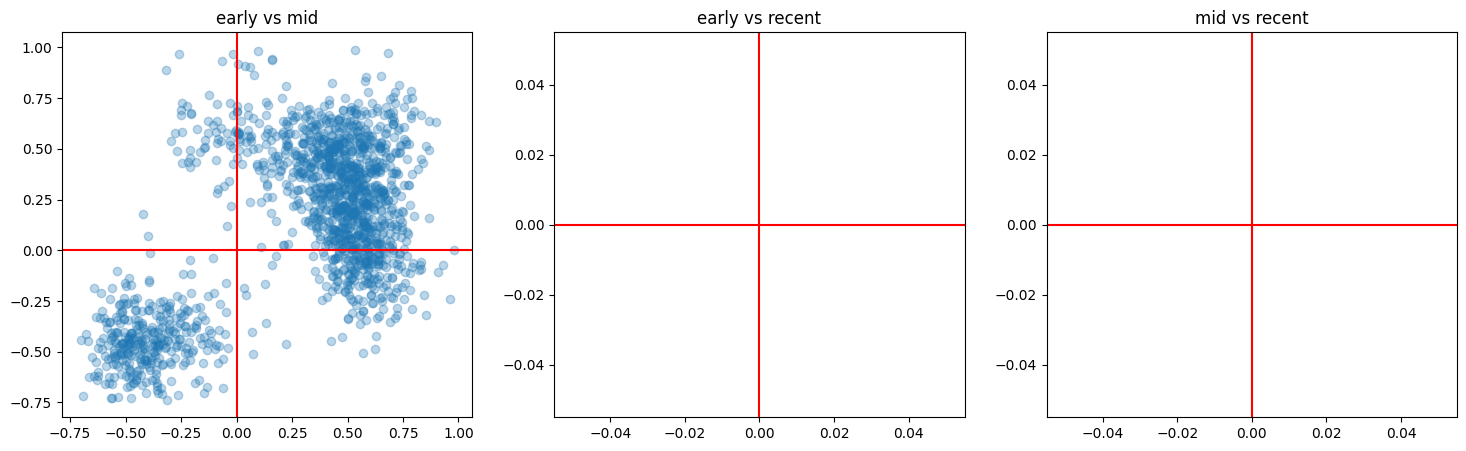

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(18,5))

ax[0].scatter(df_eda["corr_early"], df_eda["corr_mid"], alpha=0.3)
ax[0].set_title("early vs mid")
ax[0].axhline(0, color="red"); ax[0].axvline(0, color="red")

ax[1].scatter(df_eda["corr_early"], df_eda["corr_recent"], alpha=0.3)
ax[1].set_title("early vs recent")
ax[1].axhline(0, color="red"); ax[1].axvline(0, color="red")

ax[2].scatter(df_eda["corr_mid"], df_eda["corr_recent"], alpha=0.3)
ax[2].set_title("mid vs recent")
ax[2].axhline(0, color="red"); ax[2].axvline(0, color="red")

plt.show()


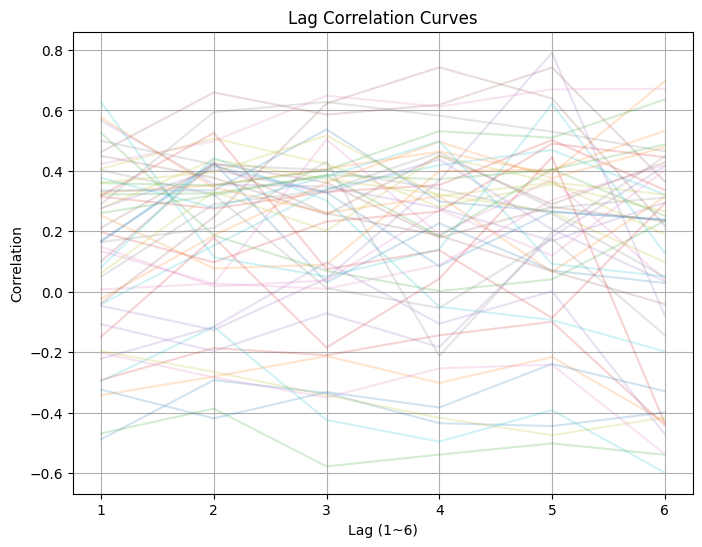

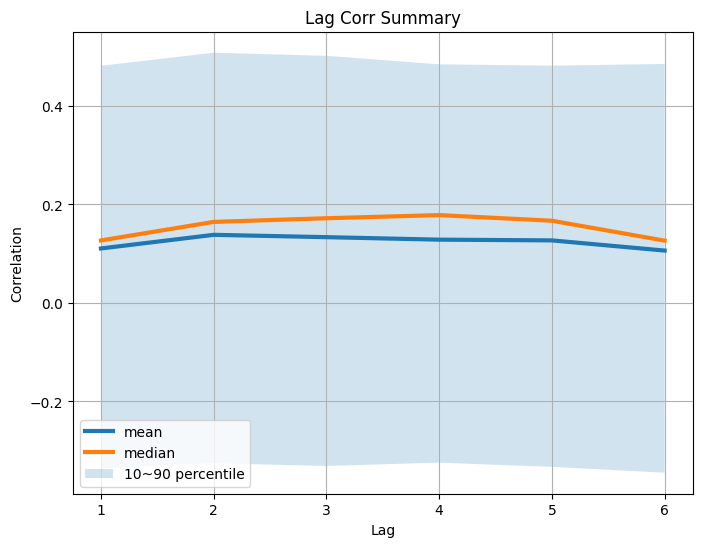

In [18]:
def lag_corr_curve(a, b, maxlag=6):
    res=[]
    for L in range(1, maxlag+1):
        if len(a) <= L:
            res.append(np.nan)
        else:
            x = a[:-L]; y = b[L:]
            if x.std()==0 or y.std()==0:
                res.append(np.nan)
            else:
                res.append(np.corrcoef(x, y)[0,1])
    return res

df_eda["corr_curve"] = df_eda.apply(
    lambda r: lag_corr_curve(
        pivot[r.leading_item_id].values,
        pivot[r.following_item_id].values,
        6
    ),
    axis=1
)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for curve in df_eda["corr_curve"].sample(50):  # 임의로 50개만
    plt.plot(range(1, 7), curve, alpha=0.2)

plt.title("Lag Correlation Curves")
plt.xlabel("Lag (1~6)")
plt.ylabel("Correlation")
plt.grid(True)
plt.show()

curves = np.vstack(df_eda["corr_curve"].dropna().values)
lags = np.arange(1, 7)

plt.figure(figsize=(8,6))
plt.plot(lags, np.nanmean(curves, axis=0), label="mean", linewidth=3)
plt.plot(lags, np.nanmedian(curves, axis=0), label="median", linewidth=3)
plt.fill_between(lags,
                 np.nanpercentile(curves, 10, axis=0),
                 np.nanpercentile(curves, 90, axis=0),
                 alpha=0.2, label="10~90 percentile")

plt.legend()
plt.title("Lag Corr Summary")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.grid(True)
plt.show()


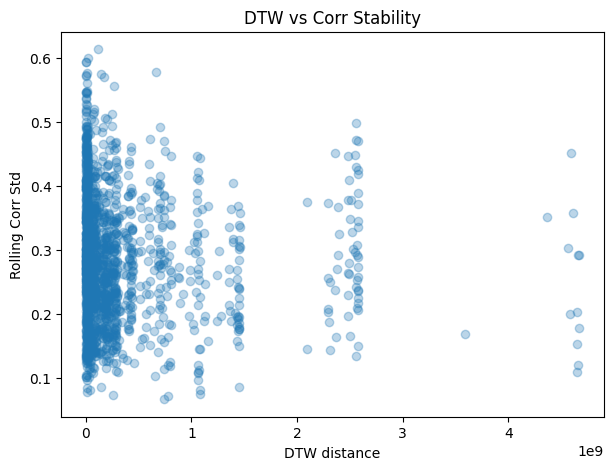

In [19]:
plt.figure(figsize=(7,5))
plt.scatter(df_eda["dtw_dist"], df_eda["rollcorr_std"], alpha=0.3)
plt.xlabel("DTW distance")
plt.ylabel("Rolling Corr Std")
plt.title("DTW vs Corr Stability")
plt.show()


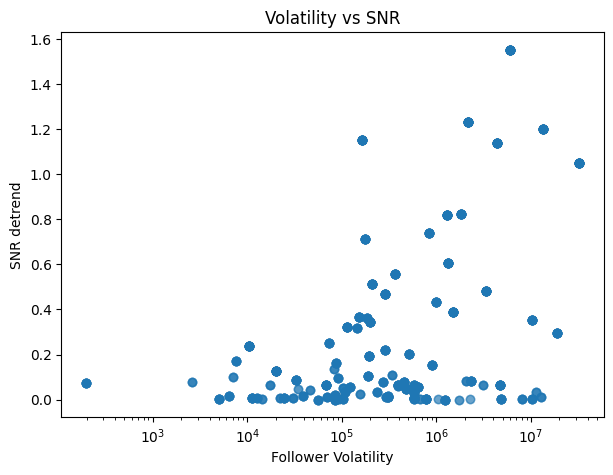

In [20]:
def compute_vol(series):
    return np.std(series)

df_eda["f_vol"] = df_eda.apply(
    lambda r: compute_vol(pivot[r.following_item_id].values),
    axis=1
)

plt.figure(figsize=(7,5))
plt.scatter(df_eda["f_vol"], df_eda["snr_detrend"], alpha=0.3)
plt.xlabel("Follower Volatility")
plt.ylabel("SNR detrend")
plt.title("Volatility vs SNR")
plt.xscale("log")
plt.show()


In [22]:
# ============================================================
# modeling_v10_lgbm_seed.py
# - v10 pairs + EDA 기반 신뢰도 필터링 + LGBM seed ensemble
# - sample_submission 사용 X → 우리가 예측한 pair만 제출
# - 전처리: pair_generate_v10_best.py 기준
# ============================================================

import pandas as pd
import numpy as np
from pathlib import Path
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error


# ============================================================
# 0. PATH 설정
# ============================================================
BASE_DIR = Path.cwd().resolve()
DATA_DIR = BASE_DIR.parents[1] / "data"

TRAIN_MONTH_PATH = DATA_DIR / "processed" / "train_month.csv"          # B안 결과
PAIRS_PATH       = DATA_DIR / "processed" / "v10_pairs" / "pairs_v10_best.csv"

OUTPUT_DIR       = DATA_DIR / "processed" / "v11_model_output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


# ============================================================
# 1. train_month → pivot 생성
#    (전처리에서 만든 train_month.csv 기반, hs4 포함)
# ============================================================
def load_monthly_data():
    df = pd.read_csv(TRAIN_MONTH_PATH)

    # year, month → ym
    df["year"] = df["year"].astype(int)
    df["month"] = df["month"].astype(int)
    df["ym"] = pd.to_datetime(
        df["year"].astype(str) + "-" + df["month"].astype(str) + "-01"
    )

    # item_id × ym pivot (value 합계)
    pivot = (
        df.pivot_table(
            index="ym",
            columns="item_id",
            values="value",
            aggfunc="sum",
        )
        .sort_index()
        .fillna(0.0)
    )
    return df, pivot


# ============================================================
# 2. single-pair 시계열 피처 생성
# ============================================================
def build_pair_frame(pivot, leader, follower, lag, corr):
    """
    - follower 시계열 b_t 기준 lag/diff/ratio
    - leader 시계열 a_t_lag, a_t_lag_1
    - target_value: 다음 달 follower value
    """
    a = pivot[leader]
    b = pivot[follower]

    df = pd.DataFrame(
        {
            "date": pivot.index,
            "b_t": b.values,
            "b_t_1": b.shift(1).values,
            "b_t_2": b.shift(2).values,
            "a_t_lag": a.shift(lag).values,
            "a_t_lag_1": a.shift(lag + 1).values,
        }
    )

    df["b_diff1"] = df["b_t"] - df["b_t_1"]
    df["b_pct1"] = df["b_diff1"] / (df["b_t_1"].replace(0, np.nan) + 1e-6)

    # target: 다음 달 follower value
    df["target_value"] = b.shift(-1).values
    df["target_log"] = np.log1p(df["target_value"].clip(lower=0))
    df["target_date"] = df["date"] + pd.offsets.MonthBegin(1)

    # 메타
    df["leading_item_id"] = leader
    df["following_item_id"] = follower
    df["lag_val"] = lag
    df["corr"] = corr

    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    return df


def build_training_data(pivot, pairs_df):
    frames = []
    for _, row in pairs_df.iterrows():
        f = build_pair_frame(
            pivot,
            row["leading_item_id"],
            row["following_item_id"],
            row["best_lag"],
            row["max_corr"],
        )
        # 너무 짧은 시계열은 제외
        if len(f) > 12:
            frames.append(f)

    if not frames:
        raise ValueError("훈련 데이터 없음. (frames 비어 있음)")

    return pd.concat(frames, ignore_index=True)


# ============================================================
# 3. LGBM seed ensemble
# ============================================================
def train_single_lgbm(X_train, y_train, X_valid, y_valid, seed):

    model = LGBMRegressor(
        objective="regression",
        n_estimators=1400,
        learning_rate=0.045,
        num_leaves=80,
        max_depth=-1,
        min_child_samples=30,
        subsample=0.8,
        subsample_freq=2,
        colsample_bytree=0.85,
        reg_lambda=3.0,
        reg_alpha=1.0,
        random_state=seed,
        verbosity=-1,
    )

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="l2",
    )

    pred = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, pred))
    return model, rmse


def train_lgbm_seed_ensemble(train_df, seeds=[42, 2024, 777]):
    """
    - target_date 기준 time-based split
      train: target_date <= 2024-12-01
      valid: 2025-01-01 ~ 2025-05-01
    """
    exclude = [
        "target_value",
        "target_log",
        "date",
        "target_date",
        "leading_item_id",
        "following_item_id",
    ]
    feature_cols = [c for c in train_df.columns if c not in exclude]

    train_cutoff = pd.Timestamp("2024-12-01")
    valid_start = pd.Timestamp("2025-01-01")
    valid_end = pd.Timestamp("2025-05-01")

    train_mask = train_df["target_date"] <= train_cutoff
    valid_mask = (train_df["target_date"] >= valid_start) & (
        train_df["target_date"] <= valid_end
    )

    X_train = train_df.loc[train_mask, feature_cols]
    y_train = train_df.loc[train_mask, "target_log"]

    X_valid = train_df.loc[valid_mask, feature_cols]
    y_valid = train_df.loc[valid_mask, "target_log"]

    if len(X_train) == 0 or len(X_valid) == 0:
        raise ValueError("train/valid 분할 후 데이터가 0입니다. (기간 확인 필요)")

    models, rmses = [], []
    for seed in seeds:
        model, rmse = train_single_lgbm(X_train, y_train, X_valid, y_valid, seed)
        print(f"[Seed {seed}] RMSE = {rmse:.5f}")
        models.append(model)
        rmses.append(rmse)

    print("Avg RMSE:", np.mean(rmses))
    return models, feature_cols


def predict_ensemble(models, X):
    preds = [m.predict(X) for m in models]
    return np.mean(preds, axis=0)


# ============================================================
# 4. inference: 마지막 row를 feature 로 사용
# ============================================================
def build_inference_features(pivot, pairs_df):
    rows = []
    for _, row in pairs_df.iterrows():
        df = build_pair_frame(
            pivot,
            row["leading_item_id"],
            row["following_item_id"],
            row["best_lag"],
            row["max_corr"],
        )
        if df.empty:
            continue
        rows.append(df.iloc[-1].copy())

    if not rows:
        return pd.DataFrame()

    return pd.DataFrame(rows).reset_index(drop=True)


# ============================================================
# 5. 제출 (우리가 찾은 pair만)
# ============================================================
def create_submission(pairs_df, pred_df, models, feature_cols):
    if pred_df.empty:
        raise ValueError("pred_df 비어 있음. (inference feature 없음)")

    sub = pairs_df[["leading_item_id", "following_item_id"]].copy()

    sub = sub.merge(
        pred_df[["leading_item_id", "following_item_id"] + feature_cols],
        on=["leading_item_id", "following_item_id"],
        how="inner",
    )

    if len(sub) == 0:
        raise ValueError("merge 후 예측 가능한 pair가 없습니다.")

    X_test = sub[feature_cols].fillna(0.0)
    y_pred = np.expm1(predict_ensemble(models, X_test))
    y_pred = np.maximum(0, y_pred)

    sub["value"] = y_pred.round().astype(int)

    print(f"[INFO] submission rows: {len(sub)}")
    return sub[["leading_item_id", "following_item_id", "value"]]


# ============================================================
# 6. MAIN (EDA 기반 필터 포함)
# ============================================================
def main():
    print("=== [1] Load monthly & pivot ===")
    _, pivot = load_monthly_data()

    print("=== [2] Load pairs_v10_best (EDA 포함) ===")
    pairs_df = pd.read_csv(PAIRS_PATH)
    print(f"[INFO] raw pairs: {len(pairs_df)}")

    # -------------------------------------------------------------
    # 🔥 EDA 기반 신뢰도 필터 적용
    #   (전처리에서 만든 컬럼들 그대로 사용)
    # -------------------------------------------------------------
    print("=== [3] Apply EDA-based filters ===")

    cond = (
        (pairs_df["max_corr"].abs() >= 0.35) &
        (pairs_df["corr_early"] * pairs_df["corr_mid"] >= 0) &
        (pairs_df["corr_range"] < 0.6) &
        (pairs_df["rollcorr_std"] < 0.40) &
        (pairs_df["dtw_dist"] < 1e9) &
        (pairs_df["f_vol"] < 5e6) &
        (pairs_df["snr_detrend"] > 0.05)
    )

    pairs_df = pairs_df.loc[cond].reset_index(drop=True)
    print(f"[INFO] filtered pairs: {len(pairs_df)}")

    if len(pairs_df) == 0:
        raise ValueError("필터 적용 후 pair가 0개입니다. (조건 완화 필요)")

    # -------------------------------------------------------------
    print("=== [4] Build training df ===")
    train_df = build_training_data(pivot, pairs_df)
    print(f"[INFO] training rows: {len(train_df)}")

    print("=== [5] Train LGBM seed ensemble ===")
    models, feature_cols = train_lgbm_seed_ensemble(train_df)

    print("=== [6] Build inference features ===")
    pred_df = build_inference_features(pivot, pairs_df)
    print(f"[INFO] pred_df rows: {len(pred_df)}")

    print("=== [7] Create submission ===")
    submission = create_submission(pairs_df, pred_df, models, feature_cols)

    out_path = OUTPUT_DIR / "submission_v11_lgbm_seed_filtered.csv"
    submission.to_csv(out_path, index=False)
    print(f"[SAVE] {out_path}")


if __name__ == "__main__":
    main()


=== [1] Load monthly & pivot ===
=== [2] Load pairs_v10_best (EDA 포함) ===
[INFO] raw pairs: 8556
=== [3] Apply EDA-based filters ===
[INFO] filtered pairs: 1105
=== [4] Build training df ===
[INFO] training rows: 39393
=== [5] Train LGBM seed ensemble ===
[Seed 42] RMSE = 2.04103
[Seed 2024] RMSE = 1.98824
[Seed 777] RMSE = 1.99209
Avg RMSE: 2.0071213693587433
=== [6] Build inference features ===
[INFO] pred_df rows: 1105
=== [7] Create submission ===
[INFO] submission rows: 1105
[SAVE] /data/ephemeral/home/data/processed/v11_model_output/submission_v11_lgbm_seed_filtered.csv
